In [23]:
import requests
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Get the data from CryptoAPI

In [138]:
res = requests.get("https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=ILS&apikey=$demo")
data = res.json()
dict_data = data['Time Series (Digital Currency Daily)']

## Working with float as type and Date as type + dropping other columns


In [161]:
features_df = pd.DataFrame.from_dict(dict_data,orient='index')
features_df = features_df[features_df.columns.drop(list(features_df.filter(regex='ILS')))]

features_df.index.name = 'Date'
features_df = features_df.reset_index()
features_df.style.format({"date": lambda t: t.strftime("%d-%m-%Y")}) 
features_df["4b. close (USD)"] = features_df["4b. close (USD)"].astype(float).round(2)
features_df = features_df.drop(columns = ['1b. open (USD)', '2b. high (USD)','5. volume','6. market cap (USD)','3b. low (USD)'])
features_df = features_df.rename(columns = {'4b. close (USD)': 'Close'})

In [162]:
features_df.head()

,Date,Close
0,2021-06-22,31615.71
1,2021-06-21,31608.93
2,2021-06-20,35600.16
3,2021-06-19,35483.72
4,2021-06-18,35819.84


In [163]:
features_df.tail()

,Date,Close
995,2018-10-01,6611.61
996,2018-09-30,6626.57
997,2018-09-29,6596.38
998,2018-09-28,6634.58
999,2018-09-27,6689.13


# Lets look on the past 100 days

### Trayding days

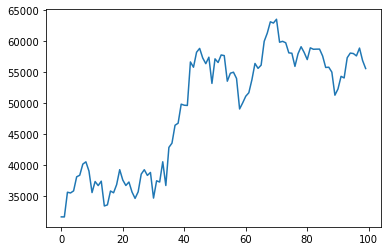

In [167]:

features_df.head()
plt.plot(features_df.head(100)['Close'])
plt.show()

In [168]:
df = features_df['Close']
df.head()

0    31615.71
1    31608.93
2    35600.16
3    35483.72
4    35819.84
Name: Close, dtype: float64

## Predict n days into the future

In [169]:
future_days = 30

## Create new column (target) shifted n days

In [170]:
features_df['Prediction'] = features_df[['Close']].shift(-future_days)
features_df.head()

,Date,Close,Prediction
0,2021-06-22,31615.71,34655.25
1,2021-06-21,31608.93,37449.73
2,2021-06-20,35600.16,37252.01
3,2021-06-19,35483.72,40526.64
4,2021-06-18,35819.84,36690.09


In [171]:
features_df.tail()

,Date,Close,Prediction
995,2018-10-01,6611.61,NaN
996,2018-09-30,6626.57,NaN
997,2018-09-29,6596.38,NaN
998,2018-09-28,6634.58,NaN
999,2018-09-27,6689.13,NaN


## Let's split the data to X & y

In [186]:
X = np.array(features_df.drop(['Prediction','Date'],1))[:-future_days]
print(X)

[[31615.71]
 [31608.93]
 [35600.16]
 [35483.72]
 [35819.84]
 [38092.97]
 [38349.01]
 [40144.04]
 [40516.29]
 [39020.57]
 [35546.11]
 [37331.98]
 [36675.72]
 [37388.05]
 [33380.81]
 [33552.79]
 [35796.31]
 [35513.2 ]
 [36829.  ]
 [39246.79]
 [37568.68]
 [36693.09]
 [37253.81]
 [35641.27]
 [34605.15]
 [35663.49]
 [38529.98]
 [39241.91]
 [38324.72]
 [38796.29]
 [34655.25]
 [37449.73]
 [37252.01]
 [40526.64]
 [36690.09]
 [42849.78]
 [43538.04]
 [46431.5 ]
 [46762.99]
 [49841.45]
 [49670.97]
 [49631.32]
 [56670.02]
 [55816.14]
 [58240.84]
 [58862.05]
 [57314.75]
 [56393.68]
 [57436.11]
 [53200.01]
 [57169.39]
 [56578.21]
 [57800.37]
 [57694.27]
 [53555.  ]
 [54846.22]
 [55011.97]
 [54001.39]
 [49066.77]
 [50047.84]
 [51125.14]
 [51690.96]
 [53787.63]
 [56425.  ]
 [55633.14]
 [56150.01]
 [60006.66]
 [61334.8 ]
 [63159.98]
 [62959.53]
 [63575.  ]
 [59860.  ]
 [60002.43]
 [59769.13]
 [58142.54]
 [58077.52]
 [55953.45]
 [57991.15]
 [59129.99]
 [58202.01]
 [57051.94]
 [58950.01]
 [58720.44]
 [58

In [187]:
y = np.array(features_df['Prediction'])[:-future_days]
print(y)

[34655.25 37449.73 37252.01 40526.64 36690.09 42849.78 43538.04 46431.5
 46762.99 49841.45 49670.97 49631.32 56670.02 55816.14 58240.84 58862.05
 57314.75 56393.68 57436.11 53200.01 57169.39 56578.21 57800.37 57694.27
 53555.   54846.22 55011.97 54001.39 49066.77 50047.84 51125.14 51690.96
 53787.63 56425.   55633.14 56150.01 60006.66 61334.8  63159.98 62959.53
 63575.   59860.   60002.43 59769.13 58142.54 58077.52 55953.45 57991.15
 59129.99 58202.01 57051.94 58950.01 58720.44 58740.55 58746.57 57635.47
 55777.63 55817.14 55025.59 51293.78 52303.65 54340.89 54083.25 57351.56
 58102.28 58030.01 57648.16 58912.97 56900.75 55605.2  58968.31 61188.39
 57221.72 57773.16 55851.59 54884.5  52375.17 50971.75 48882.2  48751.71
 48374.09 50349.37 48440.65 49587.03 45135.66 46106.43 46276.87 47073.73
 49676.2  48891.   54087.67 57408.57 55841.19 55906.   51552.6  52119.71
 49133.45 47911.1  48577.79 47153.69 47287.6  47969.51 44807.58 46420.42
 46374.87 38795.69 39186.94 38290.24 36936.66 37618.

In [188]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## Let's create our models

In [230]:
models = {"LinerRegression": LinearRegression(), "DecisionTreeRegressor": DecisionTreeRegressor()}

def model_iteration(models, X_train,X_test,y_train,y_test):
    np.random.seed(42)
    model_scores = {}
    for model,model_exec in models.items():
        model_exec.fit(X_train,y_train)
        model_scores[model] = model_exec.score(X_test,y_test)
    return model_scores
# tree = DecisionTreeRegressor().fit(X_train,y_train)
# lr = LinearRegression().fit(X_train,y_train)


In [231]:
model_score = model_iteration(models,X_train,X_test,y_train,y_test)
model_score



{'LinerRegression': 0.9102366548294661,
 'DecisionTreeRegressor': 0.8618456100573464}

(array([0, 1]),
 [Text(0, 0, 'LinerRegression'), Text(1, 0, 'DecisionTreeRegressor')])

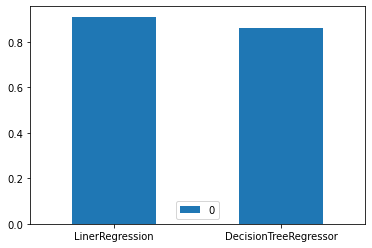

In [232]:
model_score_df = pd.DataFrame.from_dict(model_score,orient='index')
model_score_df.plot.bar()
plt.xticks(rotation=0)

## Let's go with Linear Regression

In [233]:
x_future = features_df.drop(['Prediction'],1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)


In [235]:
np.random.seed(42)
lr = LinearRegression().fit(X_train,y_train)
lr.score
# lr_prediction = lr.predict(x_future)
# lr_prediction

<bound method RegressorMixin.score of LinearRegression()>

<bound method RegressorMixin.score of LinearRegression()>